# Image Stacking (Maitek)

Primero vemos alguna imagen antes de aplicar el apilamiento de ellas:

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
EXTENSIONS = set(["bmp", "jpeg", "jpg", "png", "tif", "tiff"])

src_dir = "data_polen_IS"
src_contents = os.walk(src_dir)
dirpath, _, fnames = next(src_contents)

image_dir = os.path.split(dirpath)[-1]

print("Processing '" + image_dir + "' folder...")

image_files = sorted([os.path.join(dirpath, name) for name in fnames])
print('image_files 1', image_files)
image_files = [cv2.imread(name) for name in image_files
          if os.path.splitext(name)[-1][1:].lower() in EXTENSIONS]
print('image_files 2', image_files)

if any([image is None for image in image_files]):
    raise RuntimeError("One or more input files failed to load.")
print(image_dir + " folder is ready")

Processing 'data_polen_IS' folder...
image_files 1 ['data_polen_IS\\WIN_20190703_04_47_46_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_46_Pro (3).jpg', 'data_polen_IS\\WIN_20190703_04_47_46_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_47_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_47_Pro (3).jpg', 'data_polen_IS\\WIN_20190703_04_47_47_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_48_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_48_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_49_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_51_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_51_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_52_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_52_Pro (3).jpg', 'data_polen_IS\\WIN_20190703_04_47_52_Pro (4).jpg', 'data_polen_IS\\WIN_20190703_04_47_52_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_53_Pro (2).jpg', 'data_polen_IS\\WIN_20190703_04_47_53_Pro (3).jpg', 'data_polen_IS\\WIN_20190703_04_47_53_Pro.jpg', 'data_polen_IS\\WIN_20190703_04_47_54_Pr

In [3]:
print(dirpath)
dirpath

data_polen_IS


'data_polen_IS'

In [4]:
print(fnames)

['WIN_20190703_04_47_46_Pro (2).jpg', 'WIN_20190703_04_47_46_Pro (3).jpg', 'WIN_20190703_04_47_46_Pro.jpg', 'WIN_20190703_04_47_47_Pro (2).jpg', 'WIN_20190703_04_47_47_Pro (3).jpg', 'WIN_20190703_04_47_47_Pro.jpg', 'WIN_20190703_04_47_48_Pro (2).jpg', 'WIN_20190703_04_47_48_Pro.jpg', 'WIN_20190703_04_47_49_Pro.jpg', 'WIN_20190703_04_47_51_Pro (2).jpg', 'WIN_20190703_04_47_51_Pro.jpg', 'WIN_20190703_04_47_52_Pro (2).jpg', 'WIN_20190703_04_47_52_Pro (3).jpg', 'WIN_20190703_04_47_52_Pro (4).jpg', 'WIN_20190703_04_47_52_Pro.jpg', 'WIN_20190703_04_47_53_Pro (2).jpg', 'WIN_20190703_04_47_53_Pro (3).jpg', 'WIN_20190703_04_47_53_Pro.jpg', 'WIN_20190703_04_47_54_Pro (2).jpg', 'WIN_20190703_04_47_54_Pro (3).jpg', 'WIN_20190703_04_47_54_Pro.jpg', 'WIN_20190703_04_47_55_Pro (2).jpg', 'WIN_20190703_04_47_55_Pro (3).jpg', 'WIN_20190703_04_47_55_Pro.jpg', 'WIN_20190703_04_47_56_Pro (2).jpg', 'WIN_20190703_04_47_56_Pro (3).jpg', 'WIN_20190703_04_47_56_Pro (4).jpg', 'WIN_20190703_04_47_56_Pro.jpg', 'WI

In [5]:
print(src_contents)

<generator object walk at 0x000001812B7CBC00>


In [6]:
print(image_dir)
image_dir

data_polen_IS


'data_polen_IS'

Image 0


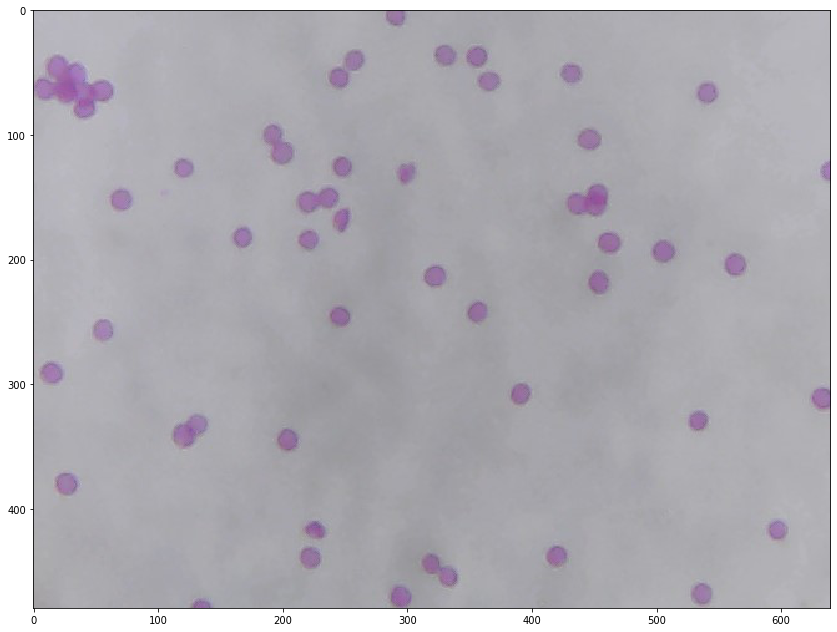

In [7]:
plt.figure(figsize=(16,11))
print('Image 0')
plt.imshow(cv2.cvtColor(image_files[0], cv2.COLOR_BGR2RGB))
plt.show()

Image 6


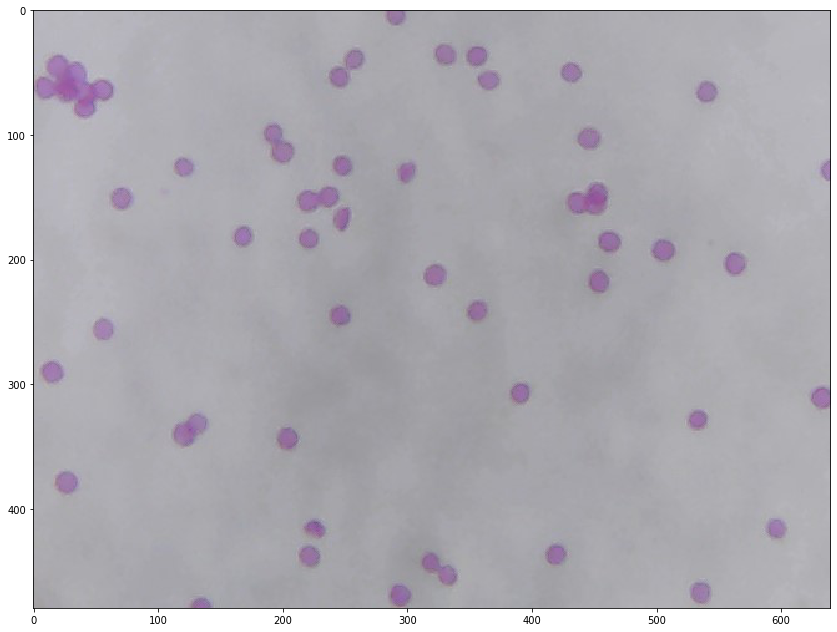

In [8]:
plt.figure(figsize=(16,11))
print('Image 6')
plt.imshow(cv2.cvtColor(image_files[7], cv2.COLOR_BGR2RGB))
plt.show()

### Algoritmo de Image Stacking:

In [9]:
import os
import cv2
import numpy as np
from time import time



# Align and stack images with ECC method
# Slower but more accurate
def stackImagesECC(file_list):
    M = np.eye(3, 3, dtype=np.float32)

    first_image = None
    stacked_image = None

    for file in file_list:
        image = cv2.imread(file,1).astype(np.float32) / 255
        print(file)
        if first_image is None:
            # convert to gray scale floating point image
            first_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            stacked_image = image
        else:
            # Estimate perspective transform
            s, M = cv2.findTransformECC(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY), first_image, M, cv2.MOTION_HOMOGRAPHY)
            w, h, _ = image.shape
            # Align image to first image
            image = cv2.warpPerspective(image, M, (h, w))
            stacked_image += image

    stacked_image /= len(file_list)
    stacked_image = (stacked_image*255).astype(np.uint8)
    return stacked_image


# Align and stack images by matching ORB keypoints
# Faster but less accurate
def stackImagesKeypointMatching(file_list):

    orb = cv2.ORB_create()

    # disable OpenCL to because of bug in ORB in OpenCV 3.1
    cv2.ocl.setUseOpenCL(False)

    stacked_image = None
    first_image = None
    first_kp = None
    first_des = None
    for file in file_list:
        print(file)
        image = cv2.imread(file,1)
        imageF = image.astype(np.float32) / 255

        # compute the descriptors with ORB
        kp = orb.detect(image, None)
        kp, des = orb.compute(image, kp)

        # create BFMatcher object
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        if first_image is None:
            # Save keypoints for first image
            stacked_image = imageF
            first_image = image
            first_kp = kp
            first_des = des
        else:
             # Find matches and sort them in the order of their distance
            matches = matcher.match(first_des, des)
            matches = sorted(matches, key=lambda x: x.distance)

            src_pts = np.float32(
                [first_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32(
                [kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Estimate perspective transformation
            M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            w, h, _ = imageF.shape
            imageF = cv2.warpPerspective(imageF, M, (h, w))
            stacked_image += imageF

    stacked_image /= len(file_list)
    stacked_image = (stacked_image*255).astype(np.uint8)
    return stacked_image

### Cargamos el directorio:

In [10]:
image_folder = "data_polen_IS"
if not os.path.exists(image_folder):
    print("ERROR {} not found!".format(image_folder))
    exit()
file_list = os.listdir(image_folder)
file_list = [os.path.join(image_folder, x)
            for x in file_list if x.endswith(('.jpg', '.png','.bmp'))]
print(image_folder + " folder is ready")

data_polen_IS folder is ready


### Method matching ORB keypoints

In [11]:
stacked_image = stackImagesKeypointMatching(file_list)

data_polen_IS\WIN_20190703_04_47_46_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_46_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_46_Pro.jpg
data_polen_IS\WIN_20190703_04_47_47_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_47_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_47_Pro.jpg
data_polen_IS\WIN_20190703_04_47_48_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_48_Pro.jpg
data_polen_IS\WIN_20190703_04_47_49_Pro.jpg
data_polen_IS\WIN_20190703_04_47_51_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_51_Pro.jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (4).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro.jpg
data_polen_IS\WIN_20190703_04_47_53_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_53_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_53_Pro.jpg
data_polen_IS\WIN_20190703_04_47_54_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_54_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_54_Pro.jpg
data_polen_IS\WIN_201907

In [ ]:
#Save image
cv2.imwrite('stacked_img_ORBresult.jpg',stacked_image)
#Show image
description = "Stacking images using ORB method"
cv2.imshow(description, stacked_image)
cv2.waitKey(0)#Permite pausar la ejecución del programa hasta que el usuario presione una tecla.

stacked_img_ORBresult


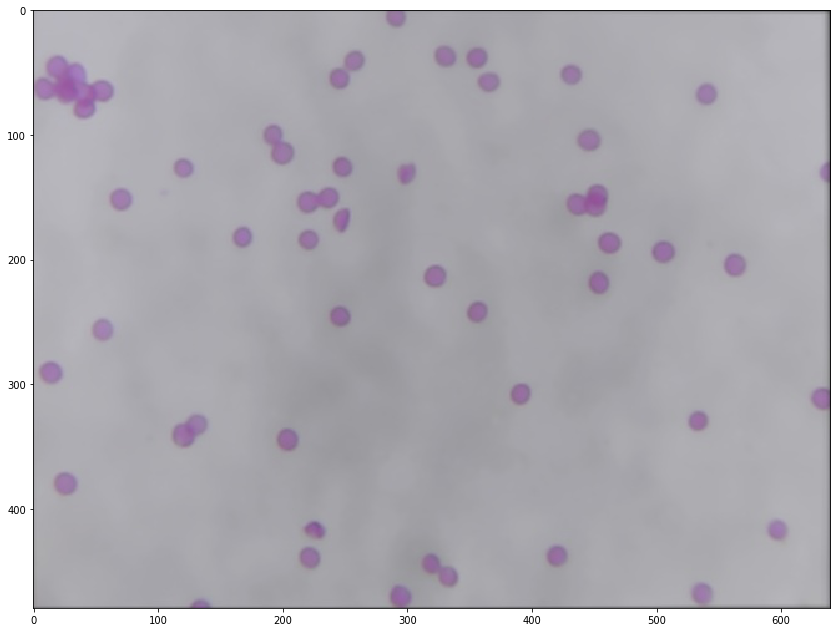

In [13]:
###################################################################
###### Se representa la imagen guardada con el resultado ECC ######
###################################################################
image_file_ECC = cv2.imread('stacked_img_ORBresult.jpg')
plt.figure(figsize=(16,11))
print('stacked_img_ORBresult')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

### Method ECC

In [14]:
stacked_image = stackImagesECC(file_list)

data_polen_IS\WIN_20190703_04_47_46_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_46_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_46_Pro.jpg
data_polen_IS\WIN_20190703_04_47_47_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_47_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_47_Pro.jpg
data_polen_IS\WIN_20190703_04_47_48_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_48_Pro.jpg
data_polen_IS\WIN_20190703_04_47_49_Pro.jpg
data_polen_IS\WIN_20190703_04_47_51_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_51_Pro.jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro (4).jpg
data_polen_IS\WIN_20190703_04_47_52_Pro.jpg
data_polen_IS\WIN_20190703_04_47_53_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_53_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_53_Pro.jpg
data_polen_IS\WIN_20190703_04_47_54_Pro (2).jpg
data_polen_IS\WIN_20190703_04_47_54_Pro (3).jpg
data_polen_IS\WIN_20190703_04_47_54_Pro.jpg
data_polen_IS\WIN_201907

In [15]:
#Save image
cv2.imwrite('stacked_img_ECCresult.jpg',stacked_image)
#Show image
description = "Stacking images using ECC method"
cv2.imshow(description, stacked_image)
#cv2.waitKey(0)#Permite pausar la ejecución del programa hasta que el usuario presione una tecla.

stacked_img_ORBresult


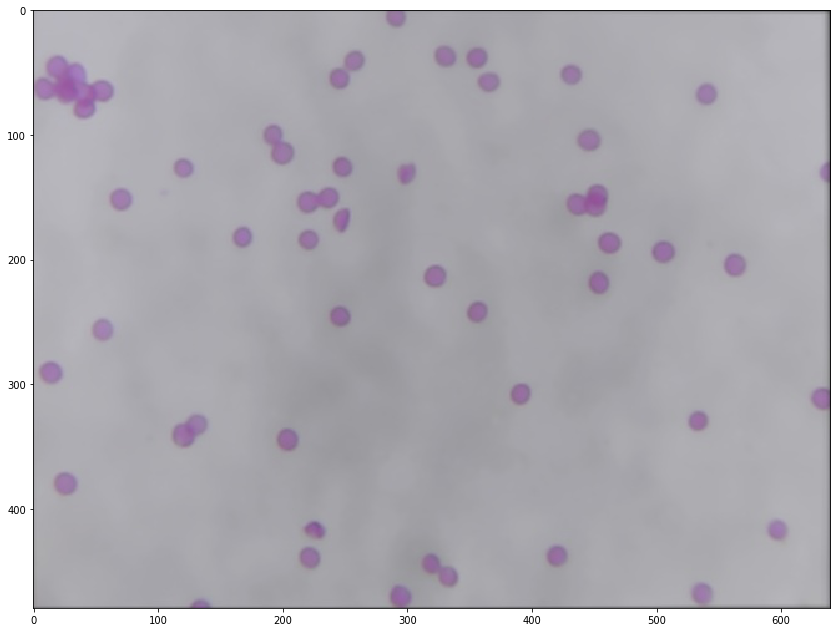

In [16]:
###################################################################
###### Se representa la imagen guardada con el resultado ECC ######
###################################################################
image_file_ECC = cv2.imread('stacked_img_ORBresult.jpg')
plt.figure(figsize=(16,11))
print('stacked_img_ORBresult')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

### Comparativa

stacked_img_ORBresult_zoom


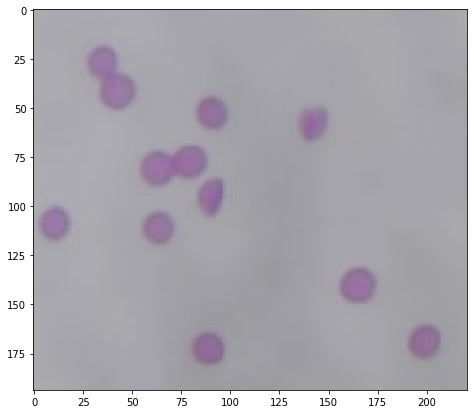

In [18]:
image_file_ECC = cv2.imread('stacked_img_ORBresult_zoom.jpg')
plt.figure(figsize=(10,7))
print('stacked_img_ORBresult_zoom')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

stacked_img_ECCresult_zoom


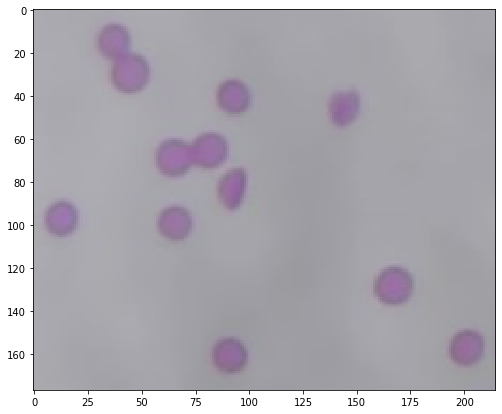

In [19]:
image_file_ECC = cv2.imread('stacked_img_ECCresult_zoom.jpg')
plt.figure(figsize=(10,7))
print('stacked_img_ECCresult_zoom')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()

polen_ruido


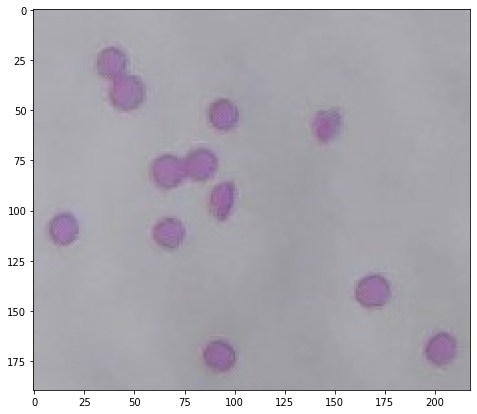

In [20]:
image_file_ECC = cv2.imread('polen_ruido.jpg')
plt.figure(figsize=(10,7))
print('polen_ruido')
plt.imshow(cv2.cvtColor(image_file_ECC, cv2.COLOR_BGR2RGB))
plt.show()